In [1]:
"""
This is an unconditional flow and does not consider the aux features
ATTEMPT TO USE Flows
https://github.com/bayesiains/nflows

still need to make use of the auxiliary features like this:
https://github.com/bayesiains/nflows/blob/master/examples/conditional_moons.ipynb
"""

'\nThis is an unconditional flow and does not consider the aux features\nATTEMPT TO USE Flows\nhttps://github.com/bayesiains/nflows\n\nstill need to make use of the auxiliary features like this:\nhttps://github.com/bayesiains/nflows/blob/master/examples/conditional_moons.ipynb\n'

In [2]:
# uncomment to use specific GPU device
# %env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=3

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MaxAbsScaler

#import keras
#import keras.layers as ll
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.externals import joblib
from IPython.display import clear_output
%matplotlib inline
from matplotlib.colors import LogNorm

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform, MaskedUMNNAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

import tqdm
from tqdm import trange
import time

## 1. Prepare the data

read the data from csv file:

In [5]:
CSV_PATH = "./data/data_for_gan_combined_ksttrain.csv"
PID_NAME = "e"

In [6]:
data_all_pids = pd.read_csv(CSV_PATH)

split columns in data to categories

In [7]:
vars_list = list(data_all_pids)
vars_list_input, vars_list_aux, vars_list_MC = [], [], []

for v in vars_list:
    if v == 'pid': 
        vars_list_MC.append(v)
    elif 'aux' in v: 
        vars_list_aux.append(v)
    else: 
        vars_list_input.append(v)

In [8]:
in_columns = ['S6aux0','S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']
out_columns = vars_list_input
IN_DIM = len(in_columns)
OUT_DIM = len(out_columns)
MODEL_NAME = "UncondFlow_Kramer_pid{}_ksttrain_nspd".format(PID_NAME)
MODEL_WEIGHTS_FILE = "./weights/%s.pt" % MODEL_NAME

In [9]:
BATCH_SIZE = int(1e4)
LATENT_DIMENSIONS = 3
TEST_SIZE = 0.3

In [10]:
def split_and_scale(data, robust_scaler=None, maxabs_scaler=None):
    # split data to train, val & test
    data_train, data_val = train_test_split(data, test_size=TEST_SIZE, random_state=42)
    data_val, data_test = train_test_split(data_val, test_size=TEST_SIZE, random_state=1812)
    
    # dropping pid column for applying preprocessing, will return it after
    pid_train = np.array(data_train["pid"])
    pid_val = np.array(data_val["pid"])
    pid_test = np.array(data_test["pid"])
    
    data_train.drop("pid", axis=1, inplace=True)
    data_val.drop("pid", axis=1, inplace=True)
    data_test.drop("pid", axis=1, inplace=True)
    
    # path to save preprocessor models to
    if not os.path.exists('gan_preprocessors'):
        os.makedrs('gan_preprocessors')
    
    # applying robust scaler
    if robust_scaler is None:
        robust_scaler = RobustScaler().fit(data_train)
        # save preprocessor model
        joblib.dump(robust_scaler, os.path.join('gan_preprocessors', MODEL_NAME) + "_robust_preprocessor.pkl")
        
    data_train = pd.DataFrame(robust_scaler.transform(data_train.values),
                              columns=data_train.columns)
    data_val = pd.DataFrame(robust_scaler.transform(data_val.values),
                            columns=data_val.columns)
    data_test = pd.DataFrame(robust_scaler.transform(data_test.values),
                            columns=data_test.columns)
    
    # applying max abs scaler
    if maxabs_scaler is None:
        maxabs_scaler = MaxAbsScaler().fit(data_train)
        # save preprocessor model
        joblib.dump(maxabs_scaler, os.path.join('gan_preprocessors', MODEL_NAME) + "_maxabs_preprocessor.pkl")
        
    data_train = pd.DataFrame(maxabs_scaler.transform(data_train),
                              columns=data_train.columns)
    data_val = pd.DataFrame(maxabs_scaler.transform(data_val),
                            columns=data_val.columns)
    data_test = pd.DataFrame(maxabs_scaler.transform(data_test),
                            columns=data_test.columns)
    
    # get back pid column
    data_train["pid"] = pid_train
    data_val["pid"] = pid_val
    data_test["pid"] = pid_test
    
    return data_train, data_val, data_test, robust_scaler, max_abs_scaler

In [11]:
# leave only data corresponding to one PID that we will build GAN for
data_pid = data_all_pids[data_all_pids.pid == PID_NAME]
try:
    robust_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_robust_preprocessor.pkl") 
    max_abs_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_maxabs_preprocessor.pkl")
except:
    robust_scaler, max_abs_scaler = None, None
data_train, data_val, data_test, robust_scaler, max_abs_scaler = split_and_scale(data_pid, robust_scaler, max_abs_scaler)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
# don't need this for GAN
data_train.drop("pid", axis=1, inplace=True)
data_val.drop("pid", axis=1, inplace=True)
data_test.drop("pid", axis=1, inplace=True)

In [13]:
aux_columns = vars_list_aux

Let's look at the distributions of the features:

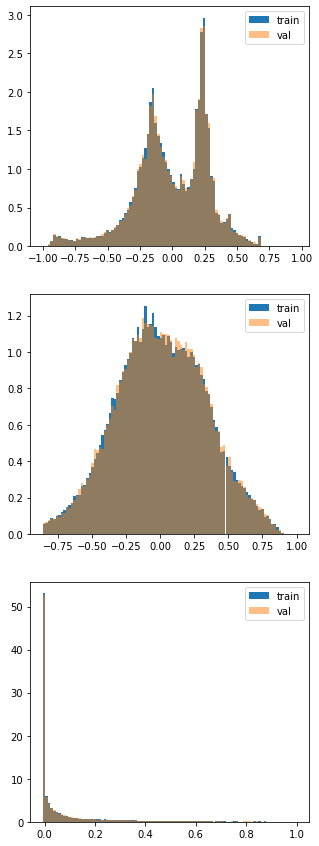

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(5, 15))
for feature_name, ax in zip(vars_list_input, axes):
    _, bins, _ = ax.hist(data_train[feature_name].values, bins=100, label="train", density=True)
    ax.hist(data_val[feature_name].values, bins=bins, label="val", alpha=0.5, density=True)
    ax.legend()
plt.show()

## 2. Building GAN

In [15]:
# rearrange columns to make them be in similar order
data_train = data_train[in_columns+out_columns]
data_val = data_val[in_columns+out_columns]
data_test = data_test[in_columns+out_columns]

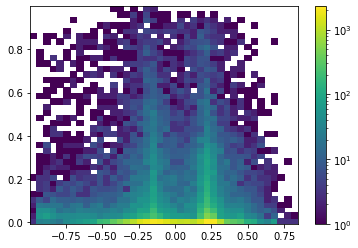

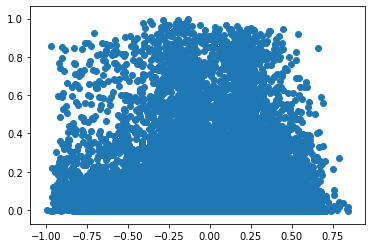

In [16]:
x_val = data_val[out_columns].to_numpy()

fig, ax = plt.subplots()
h = ax.hist2d(x_val[:, 0], x_val[:, 2], bins=40, norm=LogNorm())
fig.colorbar(h[3], ax=ax)

plt.show()

plt.scatter(x_val[:, 0], x_val[:, 2])

plt.show()


In [17]:
num_layers = 5
base_dist = StandardNormal(shape=[len(out_columns)])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=len(out_columns)))
    #transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
    #                                                      hidden_features=4))
    transforms.append(MaskedUMNNAutoregressiveTransform(features=len(out_columns), 
                                                          hidden_features=6))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [18]:
"""
# if you only have a single feature to generate
num_layers = 5
base_dist1 = StandardNormal(shape=[1])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=1))
    transforms.append(MaskedAffineAutoregressiveTransform(features=1, 
                                                          hidden_features=1))
    #transforms.append(MaskedUMNNAutoregressiveTransform(features=1, 
    #                                                      hidden_features=1))
transform1 = CompositeTransform(transforms)

flow1 = Flow(transform1, base_dist1)
optimizer1 = optim.Adam(flow1.parameters())
"""

'\n# if you only have a single feature to generate\nnum_layers = 5\nbase_dist1 = StandardNormal(shape=[1])\n\ntransforms = []\nfor _ in range(num_layers):\n    transforms.append(ReversePermutation(features=1))\n    transforms.append(MaskedAffineAutoregressiveTransform(features=1, \n                                                          hidden_features=1))\n    #transforms.append(MaskedUMNNAutoregressiveTransform(features=1, \n    #                                                      hidden_features=1))\ntransform1 = CompositeTransform(transforms)\n\nflow1 = Flow(transform1, base_dist1)\noptimizer1 = optim.Adam(flow1.parameters())\n'

In [19]:
class DatasetNumpy:
    def __init__(self, arr, arr_context=None):
        self.arr = arr
        self.arr_context = arr_context
        self.bool_context = not(arr_context is None)
        self.size = arr.shape[0]
        if self.bool_context: assert arr_context.shape[0]==arr.shape[0], "both arrays must be of the same size"
        self.nsampled = 0
        
    def get_data(self, batch_size):
        if (batch_size+ self.nsampled) >= self.size:
            res = self.arr[self.nsampled:, :].copy()
            if self.bool_context: 
                res_context = self.arr_context[self.nsampled:, :].copy()
                shuffler = np.random.permutation(self.size)
                self.arr = self.arr[shuffler]
                self.arr_context = self.arr_context[shuffler]
                self.nsampled = 0
                return res, res_context
            else:
                np.random.shuffle(self.arr)
                self.nsampled = 0
                return res
            
            
        else:
            if self.bool_context: 
                res = self.arr[self.nsampled:(self.nsampled+batch_size), :]
                res_context = self.arr_context[self.nsampled:(self.nsampled+batch_size), :]
                self.nsampled += batch_size
                return res, res_context
            else:
                res = self.arr[self.nsampled:(self.nsampled+batch_size), :]
                self.nsampled += batch_size
                return res
        
    def get_array(self):
        return self.arr

## 3. Training Flow

batches:   0%|          | 0/10000 [00:00<?, ?it/s]

Number of data points :  (135373, 3)


batches:   1%|          | 99/10000 [00:19<33:42,  4.90it/s]

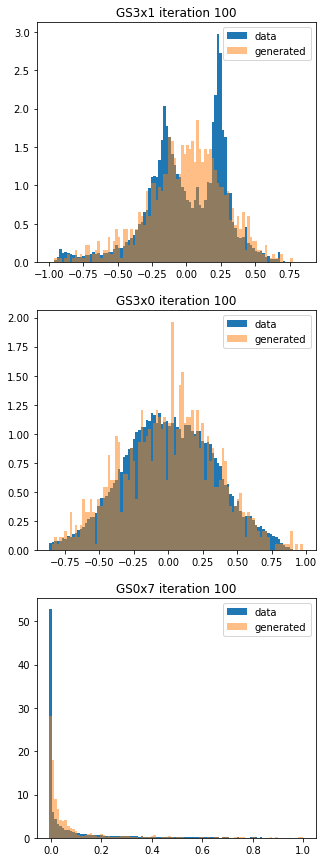

batches:   2%|▏         | 199/10000 [00:47<32:36,  5.01it/s]  

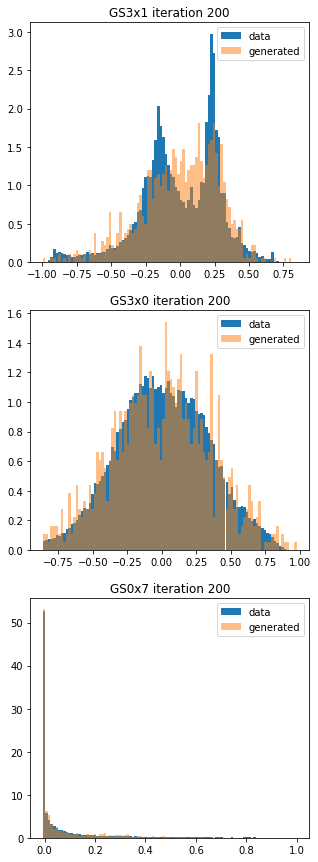

batches:   3%|▎         | 299/10000 [01:15<31:19,  5.16it/s]  

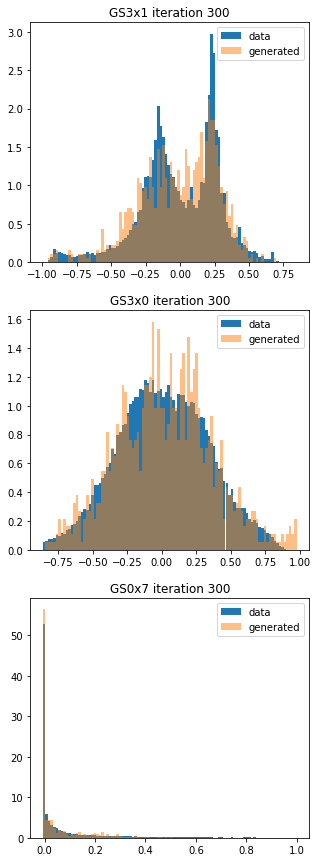

batches:   4%|▍         | 399/10000 [01:42<33:16,  4.81it/s]  

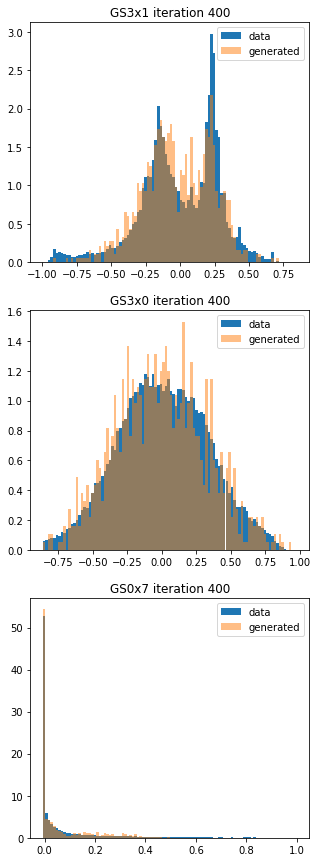

batches:   5%|▍         | 499/10000 [02:10<32:09,  4.92it/s]  

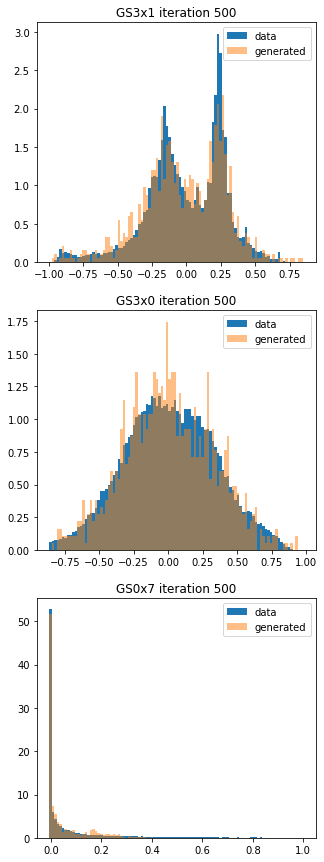

batches:   6%|▌         | 599/10000 [02:37<30:40,  5.11it/s]  

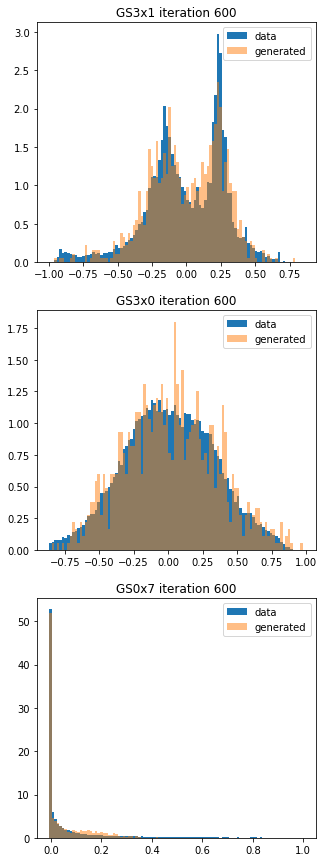

batches:   7%|▋         | 699/10000 [03:05<31:55,  4.86it/s]  

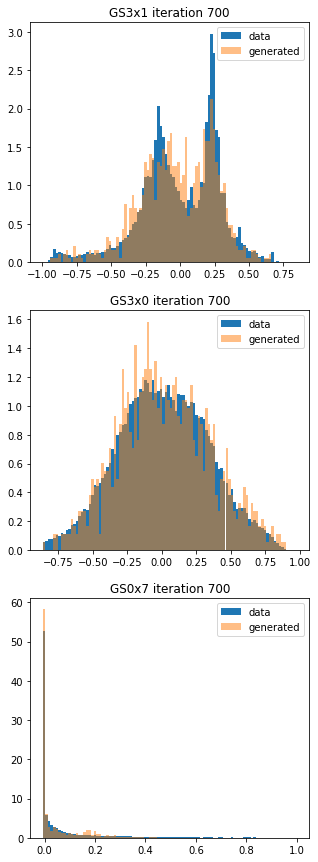

batches:   8%|▊         | 799/10000 [03:33<30:39,  5.00it/s]  

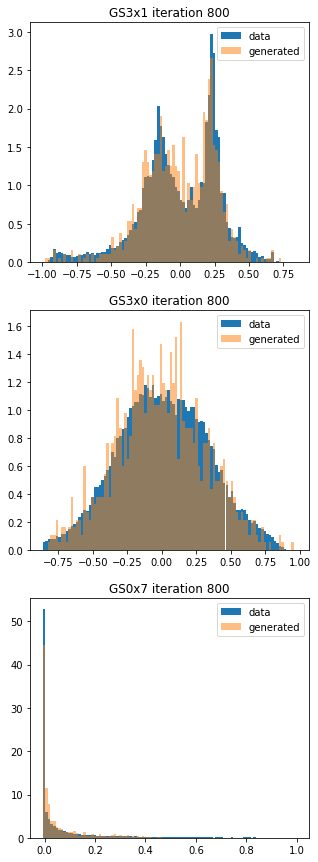

batches:   9%|▉         | 899/10000 [04:04<30:33,  4.96it/s]  

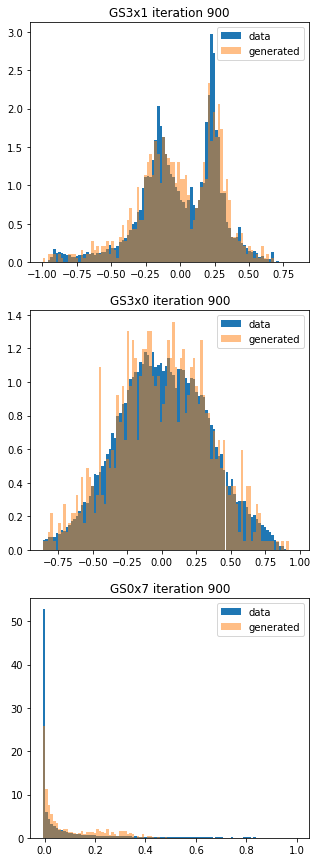

batches:  10%|▉         | 999/10000 [04:31<30:48,  4.87it/s]  

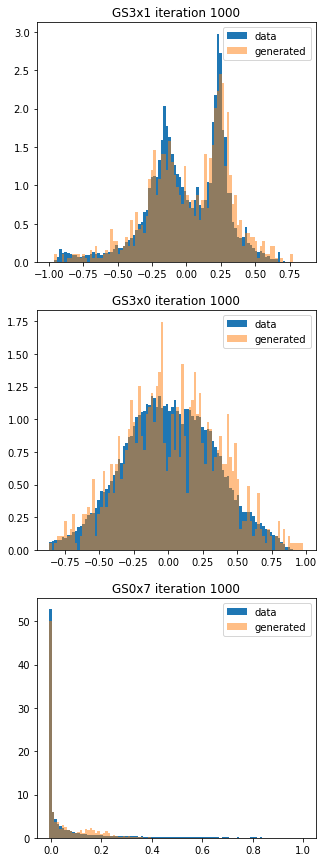

batches:  11%|█         | 1099/10000 [04:59<28:25,  5.22it/s]  

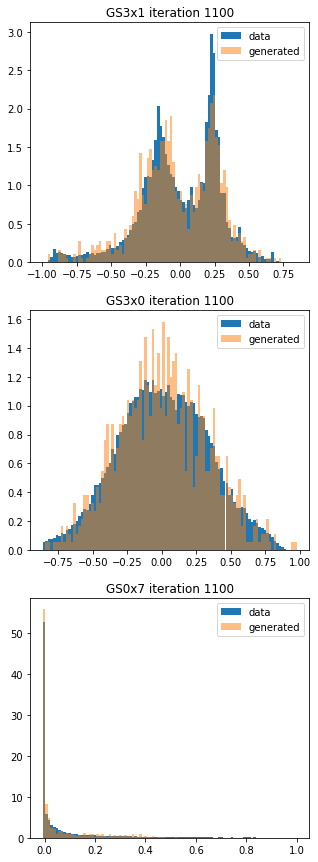

batches:  12%|█▏        | 1199/10000 [05:26<30:19,  4.84it/s]  

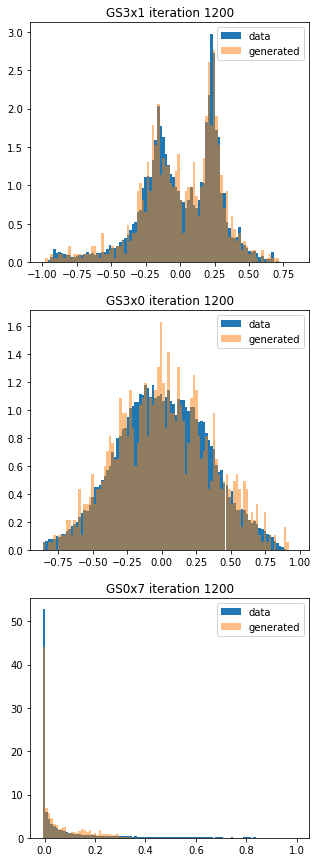

batches:  13%|█▎        | 1299/10000 [05:54<29:46,  4.87it/s]  

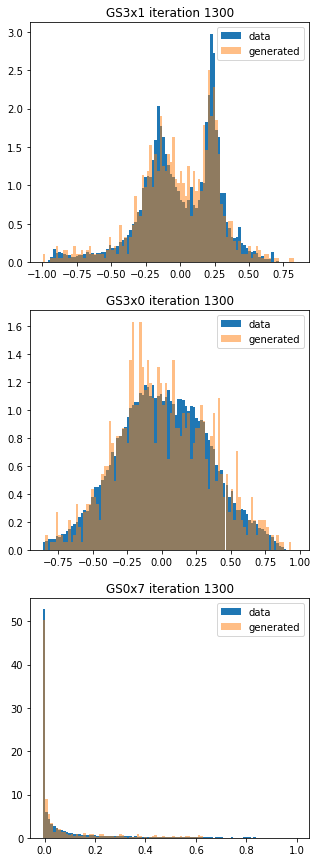

batches:  14%|█▍        | 1399/10000 [06:22<30:59,  4.63it/s]  

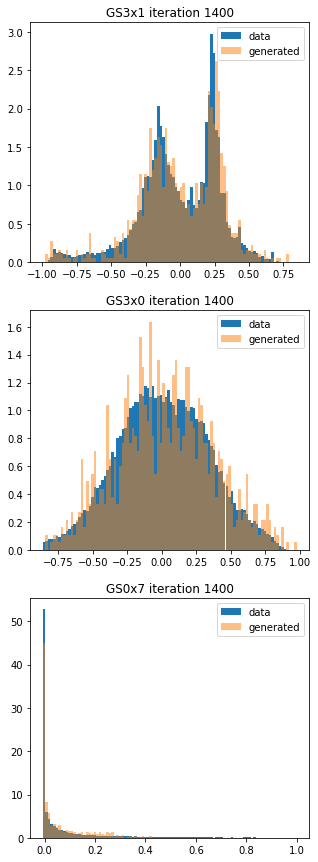

batches:  15%|█▍        | 1499/10000 [06:50<28:37,  4.95it/s]  

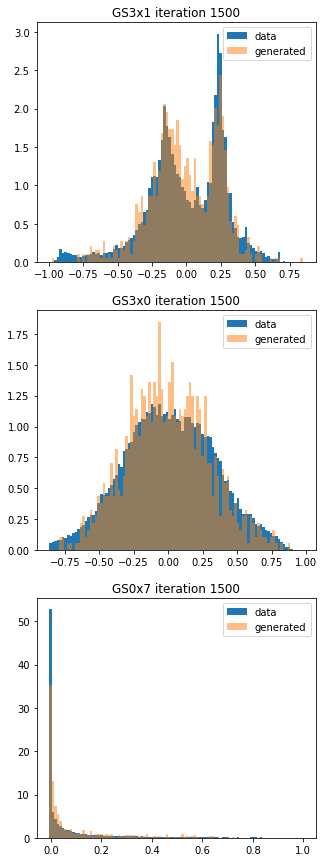

batches:  16%|█▌        | 1599/10000 [07:18<27:01,  5.18it/s]  

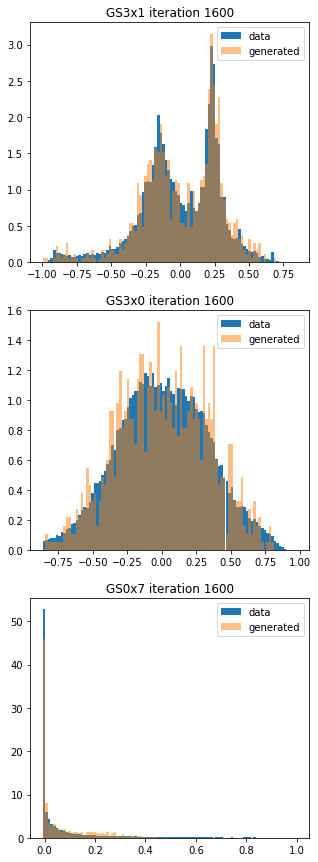

batches:  17%|█▋        | 1699/10000 [07:45<26:43,  5.18it/s]  

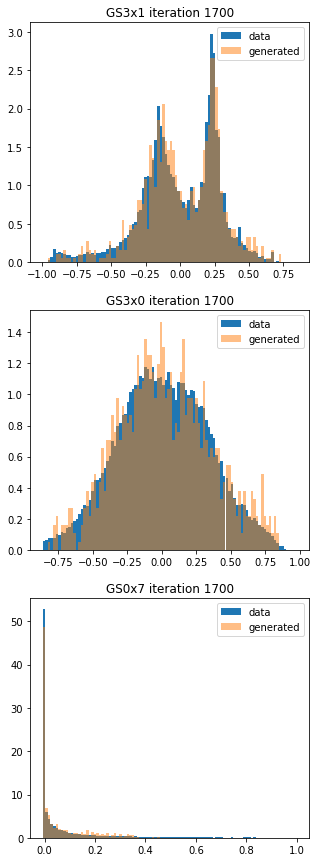

batches:  18%|█▊        | 1799/10000 [08:13<26:32,  5.15it/s]  

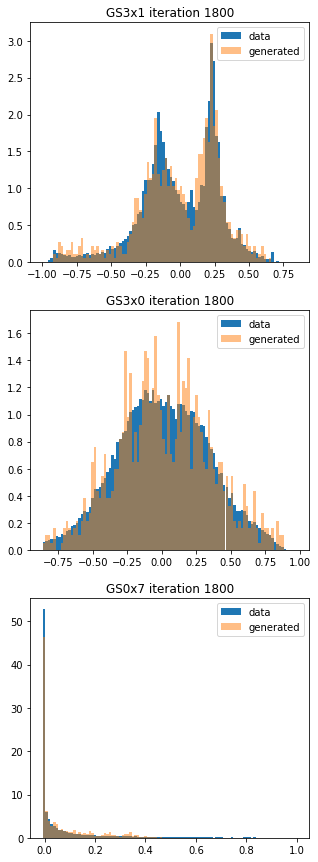

batches:  19%|█▉        | 1899/10000 [08:43<49:53,  2.71it/s]  

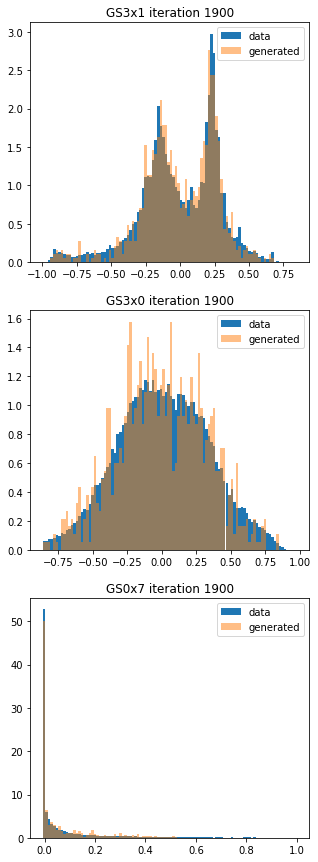

batches:  20%|█▉        | 1999/10000 [09:11<28:45,  4.64it/s]  

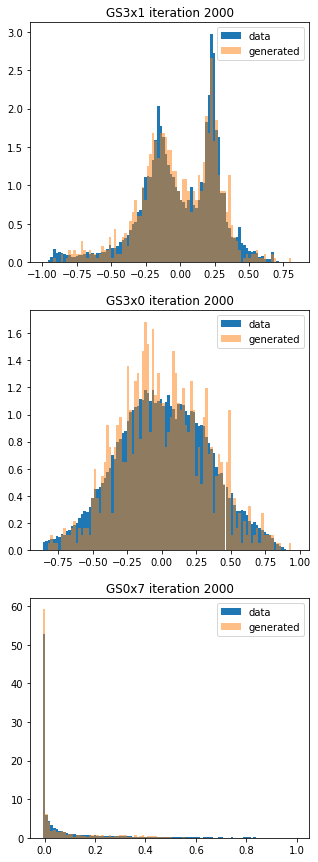

batches:  20%|██        | 2009/10000 [09:21<37:14,  3.58it/s]  


KeyboardInterrupt: 

In [20]:
train_data_saved = data_train[out_columns].to_numpy()
#np.save("train_data_saved.npy",train_data_saved)

ds = DatasetNumpy(train_data_saved[:,:])
print("Number of data points : ", train_data_saved[:,:].shape)

x_val = data_val[out_columns].to_numpy()

num_iter = 10000
num_iter = 2000
#for i in range(num_iter):
for i in trange(num_iter, desc='batches'): 
    #x, y = make_examples(500) #datasets.make_moons(500, noise=.1)
    #x = train_data_saved[:,1:]
    x = ds.get_data(500)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 100 == 0:
        #if (i + 1) % 500 == 0:
        """
        xline = torch.linspace(-1., 1)
        yline = torch.linspace(0, 1.)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), torch.zeros(xgrid.reshape(-1, 1).shape), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

        plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()
        """
        
        test_generated = flow.sample(int(1E3)).numpy()
        

        fig, axes = plt.subplots(3, 1, figsize=(5, 3*5))
        for INDEX, ax in zip((0, 1, 2), axes):
            #_, bins, _ = ax.hist(validation_np[:, INDEX+len(in_columns)], bins=100, label="data", density=True)
            _, bins, _ = ax.hist(x_val[:, INDEX], bins=100, label="data", density=True)
            ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
            ax.legend()
            ax.set_title(out_columns[INDEX]+" iteration {}".format(i+1))
        plt.show()
        #if not os.path.exists('plots'):
        #    os.makedirs('plots')
        #fig.savefig('./plots/{}.png'.format(MODEL_NAME))

In [21]:
print("Number of iterations trained {}".format(i))

Number of iterations trained 2009


In [22]:
torch.save(flow, MODEL_WEIGHTS_FILE)

In [23]:
flowbest = torch.load(MODEL_WEIGHTS_FILE)
flowbest.eval()

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): ReversePermutation()
      (1): MaskedUMNNAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=3, out_features=6, bias=True)
          (blocks): ModuleList(
            (0): MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0): MaskedLinear(in_features=6, out_features=6, bias=True)
                (1): MaskedLinear(in_features=6, out_features=6, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (1): MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0): MaskedLinear(in_features=6, out_features=6, bias=True)
                (1): MaskedLinear(in_features=6, out_features=6, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=6

After training, let's check distribution generated by GAN for test examples:

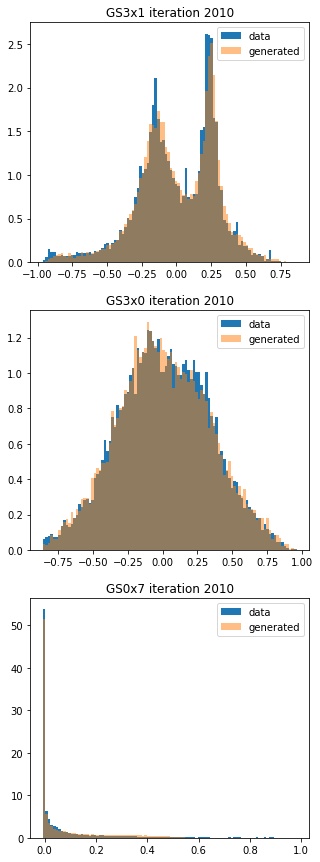

In [24]:
x_test = data_test[out_columns].to_numpy()

test_generated = flowbest.sample(x_test.shape[0]).numpy()



fig, axes = plt.subplots(3, 1, figsize=(5, 3*5))
for INDEX, ax in zip((0, 1, 2), axes):
    #_, bins, _ = ax.hist(validation_np[:, INDEX+len(in_columns)], bins=100, label="data", density=True)
    _, bins, _ = ax.hist(x_test[:, INDEX], bins=100, label="data", density=True)
    ax.hist(test_generated[:, INDEX], bins=bins, label="generated", alpha=0.5, density=True)
    ax.legend()
    ax.set_title(out_columns[INDEX]+" iteration {}".format(i+1))
plt.show()

## 4. Save GAN weights and generated test data

In [25]:
print(MODEL_NAME)
try:
    robust_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_robust_preprocessor.pkl") 
    max_abs_scaler = joblib.load(os.path.join('gan_preprocessors', MODEL_NAME) + "_maxabs_preprocessor.pkl")
except: print("fail")

UncondFlow_Kramer_pide_ksttrain_nspd


apply inverse transformations of the preprocessors on GAN output on test data:

In [26]:
test_transformed = max_abs_scaler.inverse_transform(np.concatenate([data_pid[vars_list_aux][:len(test_generated)].values, test_generated], axis=1))
test_transformed = robust_scaler.inverse_transform(test_transformed)
# save transformed test to csv
df_temp_enc = pd.DataFrame(test_transformed[:, -len(out_columns):], columns=out_columns)
df_temp_full_enc = pd.DataFrame(np.concatenate([df_temp_enc, data_test[['S6aux0', 'S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0']]], axis=1), columns=out_columns+['S6aux0','S0aux7', 'S0aux6', 'S3aux0', 'S2aux0', 'S5aux0'])
df_temp_full_enc['pid'] = [PID_NAME]*len(df_temp_full_enc)
if not os.path.exists('data'):
    os.makedirs('data')
df_temp_full_enc.to_csv("./data/generated_pid{}.csv".format(MODEL_NAME), index=None)